# In this notebook, we will be use ChatGPT promptimg for Zero-Shot language Identification

In [1]:
import os
from openai import OpenAI
import pandas as pd
import random
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import time

## Setting up ChatGPT API

In [2]:
# Setting OpenAI API key
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [3]:

# Load the input files (Only test data because we are only evaluating the model, not training anything
with open('WiLI/x_test.txt', 'r', encoding='utf-8') as f:
    x_test = f.read().splitlines()

with open('WiLI/y_test.txt', 'r', encoding='utf-8') as f:
    y_test = f.read().splitlines()

In [4]:
# Sample a random subset for evaluation
subset_size = 5000  # Reasonable balance between API cost and coverage
random.seed(42)
indices = random.sample(range(len(x_test)), subset_size)
subset_texts = [x_test[i] for i in indices]
subset_labels = [y_test[i] for i in indices]


## Querying ChatGPT for predictions

In [5]:
# Define prompt and query ChatGPT
predictions = []

for text in tqdm(subset_texts, desc="Querying ChatGPT"):
    prompt = (
        "What language is the following sentence written in?\n"
        f"Sentence: \"{text}\"\n"
        "Answer with the ISO 639-3 code (e.g., 'eng', 'deu', 'spa') only."
    )

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        
        pred = response.choices[0].message.content.strip().lower()

    except Exception as e:
        print(f"Error: {e}")
        pred = "unknown"

    predictions.append(pred)

Querying ChatGPT:  93%|█████████████████████████████████████████████████████▎   | 4674/5000 [11:12:25<47:32,  8.75s/it]

Error: Error code: 400 - {'error': {'message': "This model's maximum context length is 16385 tokens. However, your messages resulted in 19755 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


Querying ChatGPT: 100%|█████████████████████████████████████████████████████████| 5000/5000 [11:59:22<00:00,  8.63s/it]


## Evaluating the outputs

In [11]:
# Evaluation
true = [label.lower() for label in subset_labels]


report = classification_report(true, predictions, zero_division=0)
print("\nChatGPT Zero-Shot Evaluation Report:")
print(report)

with open("chatgpt_classification_report.txt", "w", encoding="utf-8") as f:
    f.write("ChatGPT Zero-Shot Language Classification Report\n")
    f.write("="*60 + "\n")
    f.write(report)

acc = accuracy_score(true, predictions)
f1 = f1_score(true, predictions, average='macro', zero_division=0)
precision = precision_score(true, predictions, average='macro', zero_division=0)
recall = recall_score(true, predictions, average='macro', zero_division=0)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


ChatGPT Zero-Shot Evaluation Report:
                           precision    recall  f1-score   support

                    'ita'       0.00      0.00      0.00         0
          'ita' (italian)       0.00      0.00      0.00         0
                    'kaa'       0.00      0.00      0.00         0
                      abk       0.00      0.00      0.00         0
                      ace       1.00      0.82      0.90        22
                      afr       0.97      1.00      0.98        28
                      alb       0.00      0.00      0.00         0
                      als       1.00      0.05      0.09        22
                      amh       0.86      0.92      0.89        26
                      ang       1.00      0.93      0.96        28
                      ara       0.51      1.00      0.68        21
                      arg       1.00      0.44      0.61        16
                      arz       0.00      0.00      0.00        20
                      a

In [12]:
# Save results to CSV
eval_df = pd.DataFrame({
    "text": subset_texts,
    "true_label": true,
    "chatgpt_prediction": predictions
})

eval_df.to_csv("chatgpt_wili_results.csv", index=False)
print("\nResults saved to chatgpt_wili_results.csv")


Results saved to chatgpt_wili_results.csv


In [13]:
from sklearn.preprocessing import LabelEncoder

# Combine labels to cover all seen codes
all_labels = list(set(true + predictions))

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_true = label_encoder.transform(true)
y_pred = label_encoder.transform(predictions)


In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)


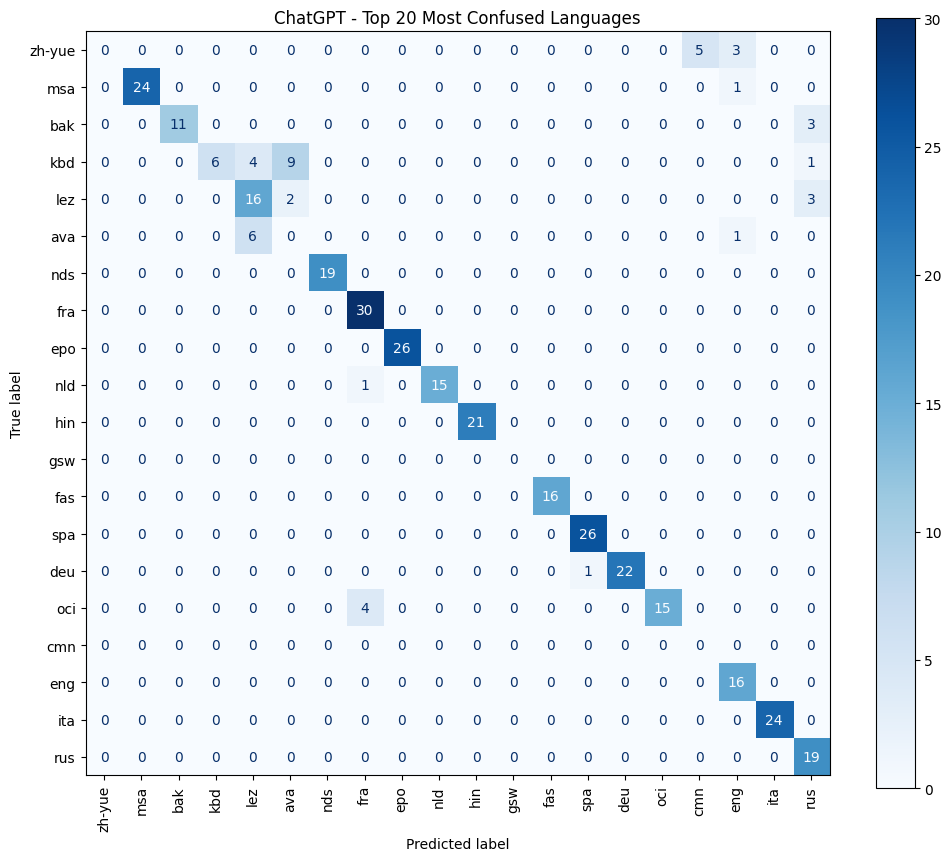

In [15]:
# Remove diagonal to highlight errors
errors = cm.copy()
np.fill_diagonal(errors, 0)
confusion_sums = errors.sum(axis=1) + errors.sum(axis=0)

# Top 20 most confused
N = 20
top_n_indices = np.argsort(confusion_sums)[-N:]

small_cm = cm[np.ix_(top_n_indices, top_n_indices)]
small_labels = [label_encoder.classes_[i] for i in top_n_indices]

fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=small_cm, display_labels=small_labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.0f', cmap='Blues')
plt.title(f"ChatGPT - Top {N} Most Confused Languages")
plt.show()
fig.savefig("ChatGPT_confusion_matrix_top20.png", dpi=300, bbox_inches='tight')